In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error

import seaborn as sns


In [46]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [47]:
train.shape

(1285000, 14)

In [48]:
train.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,9.960940,1.491492,1.199018,-0.063145,0.595242,1.018416,1.248499,0.674080,-0.034194,-2.509908,-2.447517,-0.610936,-0.561048,255
256,10.000000,1.485476,1.222565,-0.250131,0.609230,1.048258,1.246830,0.859066,-0.050144,-2.533734,-2.469395,-0.608935,-0.559086,256
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,-0.555739,0.000000,0.000000,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,-0.555279,0.022176,0.023556,258


In [49]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [50]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

# convert trajectory indices into row indices
row_indices = [i * 257 for i in traj_zero]

print("Trajectories starting with zeros:", traj_zero)
print("Corresponding starting rows:", row_indices)

Trajectories starting with zeros: [1050, 4058]
Corresponding starting rows: [269850, 1042906]


In [51]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [52]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

In [53]:
def remove_collision(df, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end]

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero = zero_mask.argmax() + start
            traj = traj.loc[start:first_zero-1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [54]:
train_cleaned = remove_collision(train_cleaned)

CHECK ANOMALIES ON THE DATABASE TRAIN_CLEANED

In [56]:
def check_dataset_anomalies(df):
    print("Dataset anomalies check\n")

    # 1. Check for missing values (NaN)
    missing = df.isnull().sum().sum()
    if missing == 0:
        print("No missing values (NaN) found.")
    else:
        print(f"Found {missing} missing values (NaN).")
        print(df.isnull().sum()[df.isnull().sum() > 0])

    # 2. Check for infinite values
    inf_mask = df.isin([np.inf, -np.inf])
    inf_count = inf_mask.sum().sum()
    if inf_count == 0:
        print("No infinite values (+inf, -inf) found.")
    else:
        print(f"Found {inf_count} infinite values.")
        print(inf_mask.sum()[inf_mask.sum() > 0])

    # 3. Check for empty columns
    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    if not empty_cols:
        print("No empty columns.")
    else:
        print(f"Found empty columns: {empty_cols}")


In [57]:
check_dataset_anomalies(train_cleaned)

Dataset anomalies check

No missing values (NaN) found.
No infinite values (+inf, -inf) found.
No empty columns.


CHECK THE STATISTICS OF THE DATASET

In [155]:
def dataset_summary(df):
    # --- Dimensions ---
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")

    # --- Basic statistics ---
    print("Basic statistics per column:")
    desc = df.describe().T
    print(desc[['min', 'mean', 'max']])

    # --- Standard deviation ---
    desc['std'] = df.std()
    print("\nStandard deviation:")
    print(desc['std'])

    # --- Group columns ---
    coord_cols = [col for col in df.columns if col.startswith(('x_', 'y_'))]
    vel_cols = [col for col in df.columns if col.startswith(('v_x', 'v_y'))]

    # --- Boxplots (valeurs absolues en log, comme avant) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Coordinates
    data_coord = [np.abs(df[c]) + 1e-8 for c in coord_cols]
    axes[0].boxplot(data_coord, tick_labels=coord_cols)
    axes[0].set_yscale('log')
    axes[0].set_title("Coordinates (x, y) - log scale (abs values)")
    axes[0].set_xlabel("Variables")
    axes[0].set_ylabel("Values (log scale)")

    # Velocities
    data_vel = [np.abs(df[c]) + 1e-8 for c in vel_cols]
    axes[1].boxplot(data_vel, tick_labels=vel_cols)
    axes[1].set_yscale('log')
    axes[1].set_title("Velocities (v_x, v_y) - log scale (abs values)")
    axes[1].set_xlabel("Variables")
    axes[1].set_ylabel("Values (log scale)")

    plt.tight_layout()
    plt.show()

    # --- Histogrammes simples (pas de log) ---
    def plot_raw_hist(df, cols, color, group_name):
        for col in cols:
            plt.figure(figsize=(6, 3))
            plt.hist(df[col], bins=50, color=color, edgecolor='black')
            plt.title(f"{col} - Raw distribution ({group_name})")
            plt.xlabel("Value")
            plt.ylabel("Frequency")
    
            # ➕ Afficher min et max
            min_val = df[col].min()
            max_val = df[col].max()
            plt.annotate(f"min: {min_val:.2e}", xy=(0.98, 0.95), xycoords='axes fraction',
                         ha='right', va='top', fontsize=9, color='red')
            plt.annotate(f"max: {max_val:.2e}", xy=(0.98, 0.88), xycoords='axes fraction',
                         ha='right', va='top', fontsize=9, color='red')
    
            plt.tight_layout()
            plt.show()


    # Coordinates
    plot_raw_hist(df, coord_cols, color='skyblue', group_name='Coordinates')

    # Velocities
    plot_raw_hist(df, vel_cols, color='lightcoral', group_name='Velocities')

Shape: 1089790 rows, 13 columns

Basic statistics per column:
             min      mean        max
t       0.000000  4.887787  10.000000
x_1   -30.823004 -0.331674  16.340610
y_1   -17.857729 -0.129133  26.276226
v_x_1 -72.993333 -0.217109  23.503455
v_y_1 -23.109278 -0.019456  34.671679
x_2   -30.833398  0.008456  15.506957
y_2   -52.450808 -0.096702  35.679463
v_x_2 -25.895550  0.038295  72.718229
v_y_2 -48.289007 -0.098585  23.118346
x_3   -17.439994  0.323218  61.656402
y_3   -33.159997  0.225835  27.735539
v_x_3 -30.970540  0.178814  25.964992
v_y_3 -25.509384  0.118041  48.288738

Standard deviation:
t        2.918751
x_1      1.836845
y_1      1.266963
v_x_1    0.949104
v_y_1    0.875636
x_2      1.154264
y_2      1.127168
v_x_2    1.016519
v_y_2    1.058225
x_3      1.562294
y_3      1.825727
v_x_3    0.852717
v_y_3    0.944614
Name: std, dtype: float64


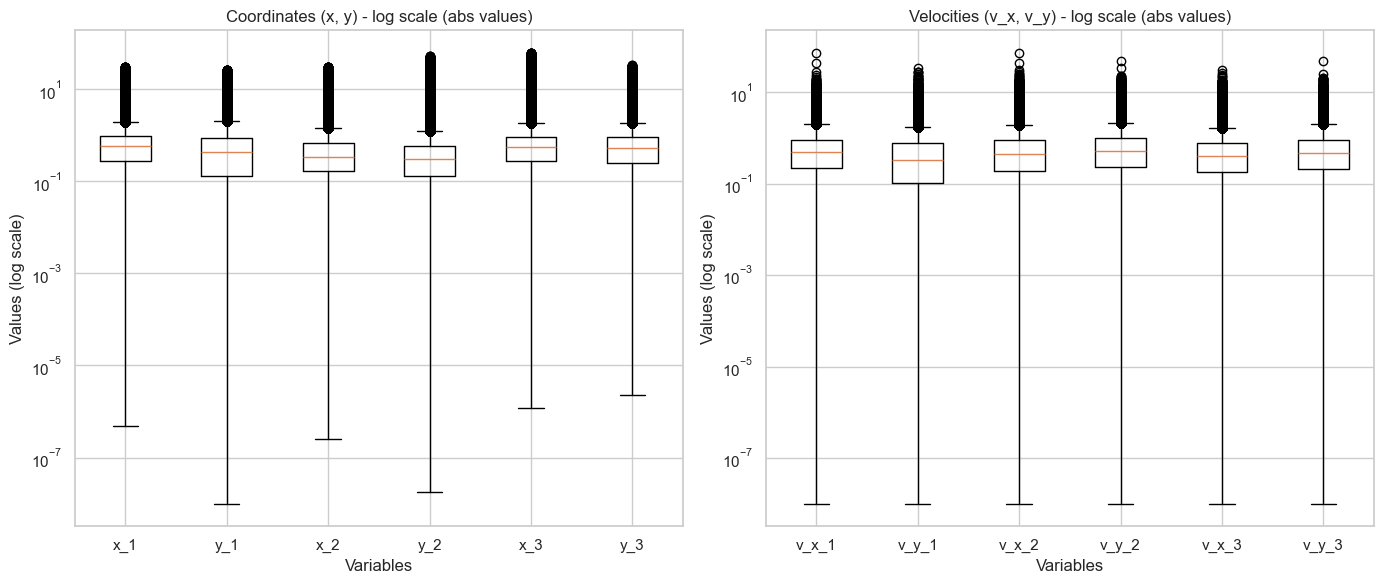

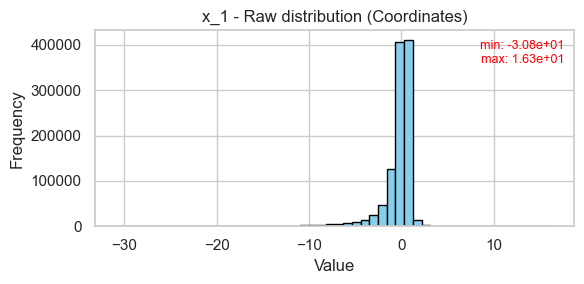

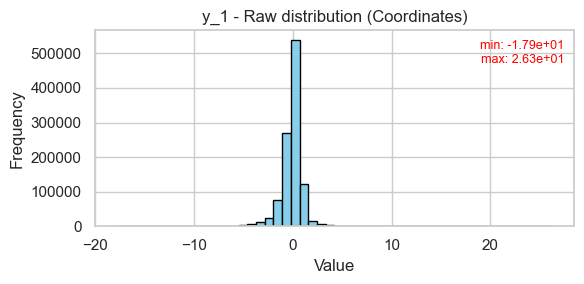

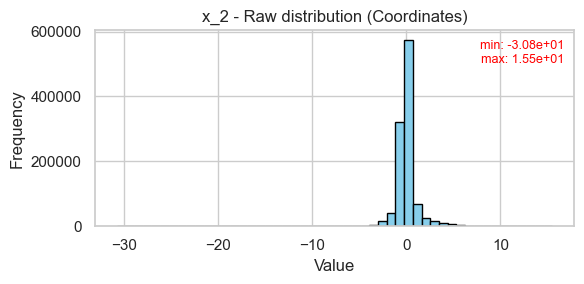

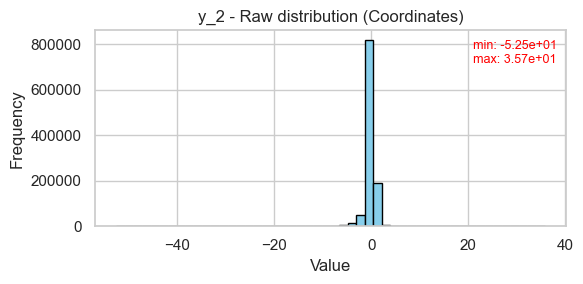

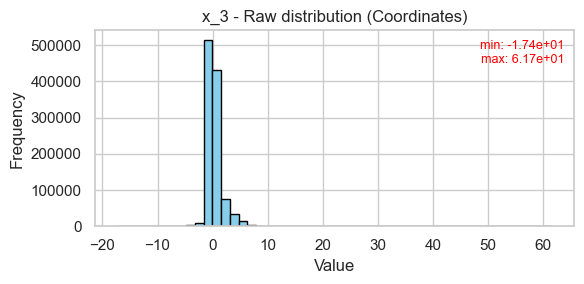

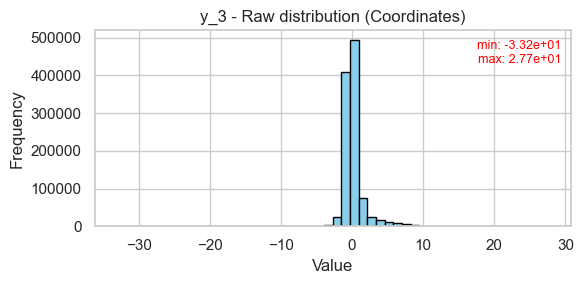

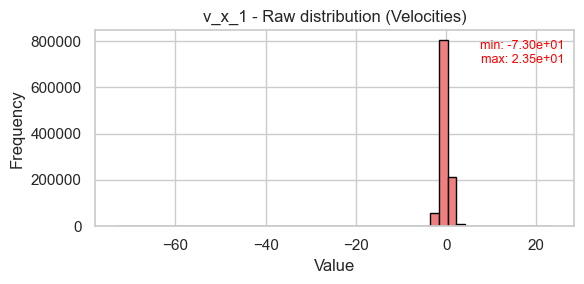

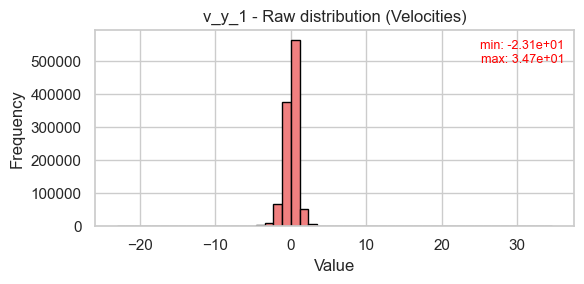

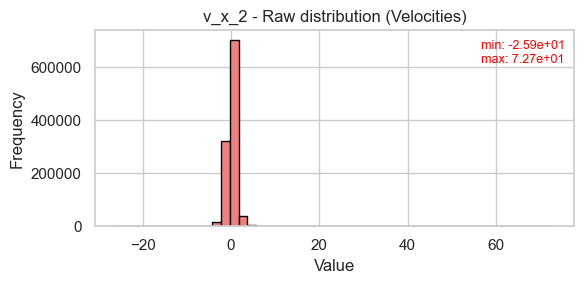

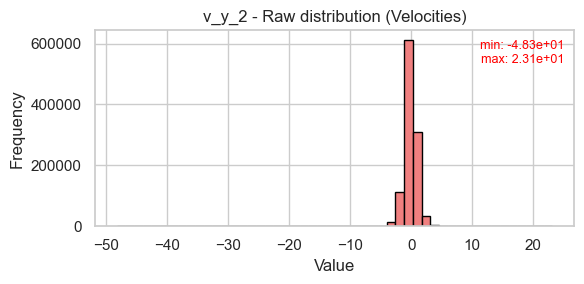

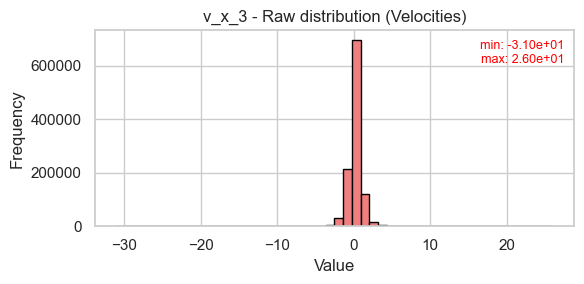

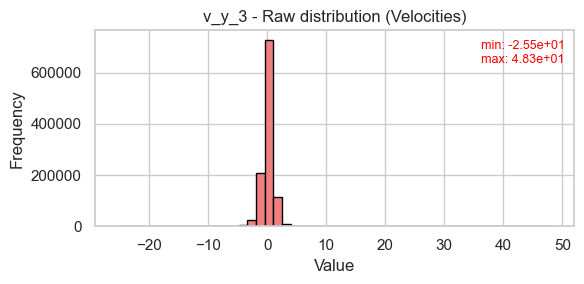

In [157]:
train_cleaned_no_id = train_cleaned.iloc[:, :-1]
dataset_summary(train_cleaned_no_id)

#task 1.1

In [62]:
def split_trajectories(df, 
                                train_size=0.6, 
                                validation_size=0.2, 
                                test_size=0.2, 
                                method="random", 
                                random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    # Identifier les indices de début de trajectoire
    traj_start_indices = df.index[df['t'] == 0].tolist()
    traj_start_indices.append(len(df))  # ajouter la fin pour le dernier bloc

    # Construire les slices de trajectoires
    traj_slices = [(traj_start_indices[i], traj_start_indices[i+1]) for i in range(len(traj_start_indices)-1)]
    
    if method == "random":
        np.random.shuffle(traj_slices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_traj = len(traj_slices)
    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si reste
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining

    train_slices = traj_slices[:n_train]
    val_slices = traj_slices[n_train:n_train+n_val]
    test_slices = traj_slices[n_train+n_val:n_train+n_val+n_test]

    # Concaténer les DataFrames correspondants
    train_df = pd.concat([df.iloc[start:end] for start, end in train_slices])
    val_df = pd.concat([df.iloc[start:end] for start, end in val_slices])
    test_df = pd.concat([df.iloc[start:end] for start, end in test_slices])

    return train_df, val_df, test_df


In [63]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [64]:
print(train_after_split.shape)
print(validation_after_split.shape)
print(test_after_split.shape)

(649720, 14)
(222023, 14)
(218047, 14)


In [65]:
# Récupérer les ensembles d'IDs pour chaque split
train_ids = set(train_after_split['Id'].unique())
val_ids = set(validation_after_split['Id'].unique())
test_ids = set(test_after_split['Id'].unique())

# Vérifier les intersections
print("Train ∩ Validation :", train_ids & val_ids)
print("Train ∩ Test :", train_ids & test_ids)
print("Validation ∩ Test :", val_ids & test_ids)

Train ∩ Validation : set()
Train ∩ Test : set()
Validation ∩ Test : set()


In [66]:
train_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
506736,0.000000,1.000000,0.000000,0.000000,0.000000,-0.260989,0.293772,0.000000,0.000000,-0.739011,-0.293772,0.000000,0.000000,589815
506737,0.039062,0.999315,0.000062,-0.035094,0.003190,-0.261386,0.292636,-0.020375,-0.058216,-0.737928,-0.292698,0.055468,0.055026,589816
506738,0.078125,0.997257,0.000249,-0.070291,0.006352,-0.262589,0.289215,-0.041349,-0.117125,-0.734668,-0.289464,0.111640,0.110774,589817
506739,0.117188,0.993821,0.000558,-0.105696,0.009454,-0.264633,0.283467,-0.063576,-0.177476,-0.729188,-0.284025,0.169272,0.168022,589818
506740,0.156250,0.988995,0.000986,-0.141416,0.012465,-0.267582,0.275320,-0.087828,-0.240138,-0.721413,-0.276306,0.229243,0.227673,589819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506991,9.960940,3.389555,1.492060,0.399110,0.227916,-1.800285,-0.799376,-0.068963,1.210530,-1.589270,-0.692684,-0.330147,-1.438446,590070
506992,10.000000,3.405100,1.500943,0.396803,0.226899,-1.787229,-0.747065,0.857428,1.412064,-1.617871,-0.753879,-1.254230,-1.638962,590071
602833,0.000000,1.000000,0.000000,0.000000,0.000000,-0.352089,0.615896,0.000000,0.000000,-0.647911,-0.615896,0.000000,0.000000,705208
602834,0.039062,0.999454,0.000057,-0.027938,0.002918,-0.351885,0.615290,0.010423,-0.031019,-0.647569,-0.615347,0.017516,0.028102,705209


In [67]:
validation_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
542380,0.000000,1.000000,0.000000,0.000000,0.000000,-0.406828,0.376060,0.000000,0.000000,-0.593172,-0.376060,0.000000,0.000000,633505
542381,0.039062,0.999375,0.000027,-0.032002,0.001406,-0.406786,0.374732,0.002120,-0.068050,-0.592589,-0.374760,0.029882,0.066644,633506
542382,0.078125,0.997498,0.000110,-0.064115,0.002802,-0.406664,0.370732,0.004058,-0.136971,-0.590834,-0.370842,0.060058,0.134168,633507
542383,0.117188,0.994363,0.000246,-0.096453,0.004178,-0.406474,0.364008,0.005612,-0.207700,-0.587889,-0.364254,0.090841,0.203523,633508
542384,0.156250,0.989959,0.000436,-0.129132,0.005520,-0.406234,0.354468,0.006541,-0.281327,-0.583725,-0.354904,0.122591,0.275807,633509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542635,9.960940,-0.361533,-0.275257,0.317070,0.273319,-0.196203,0.256055,0.954998,-0.509437,0.557736,0.019201,-1.272069,0.236118,633760
542636,10.000000,-0.347531,-0.261908,0.402779,0.412160,-0.158435,0.233352,0.979613,-0.655339,0.505966,0.028555,-1.382393,0.243178,633761
899009,0.000000,1.000000,0.000000,0.000000,0.000000,-0.204878,0.266231,0.000000,0.000000,-0.795122,-0.266231,0.000000,0.000000,1059354
899010,0.039062,0.999281,0.000074,-0.036800,0.003790,-0.205286,0.265313,-0.020936,-0.047013,-0.793995,-0.265388,0.057736,0.043222,1059355


In [68]:
test_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
132141,0.000000,1.000000,0.000000,0.000000,0.000000,-0.070607,0.282796,0.000000,0.000000,-0.929393,-0.282796,0.000000,0.000000,154714
132142,0.039062,0.999200,0.000130,-0.040989,0.006646,-0.070609,0.282240,-0.000059,-0.028467,-0.928591,-0.282370,0.041048,0.021822,154715
132143,0.078125,0.996796,0.000519,-0.082126,0.013289,-0.070613,0.280571,-0.000167,-0.057010,-0.926183,-0.281090,0.082292,0.043721,154716
132144,0.117188,0.992780,0.001168,-0.123558,0.019928,-0.070623,0.277784,-0.000374,-0.085705,-0.922157,-0.278952,0.123932,0.065777,154717
132145,0.156250,0.987137,0.002076,-0.165442,0.026559,-0.070644,0.273872,-0.000737,-0.114631,-0.916493,-0.275948,0.166178,0.088072,154718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132396,9.960940,0.499234,-0.056764,-1.468353,-0.156906,-0.086259,0.287584,0.388074,0.271596,-0.412974,-0.230820,1.080279,-0.114690,154969
132397,10.000000,0.439457,-0.062152,-1.595682,-0.117051,-0.070676,0.295523,0.411942,0.131725,-0.368781,-0.233371,1.183740,-0.014674,154970
917560,0.000000,1.000000,0.000000,0.000000,0.000000,-0.140192,0.689722,0.000000,0.000000,-0.859808,-0.689722,0.000000,0.000000,1081456
917561,0.039062,0.999450,0.000155,-0.028143,0.007937,-0.139970,0.689220,0.011365,-0.025702,-0.859481,-0.689375,0.016778,0.017765,1081457


#task 1.2

In [70]:
def replicate_initial_position_by_block(df):
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]
    
    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values
    
    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc
    
    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée
        
    
    copy[coords] = data
    return copy


In [71]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [72]:
train_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
506736,0.000000,1.0,0.0,0.000000,0.000000,-0.260989,0.293772,0.000000,0.000000,-0.739011,-0.293772,0.000000,0.000000,589815
506737,0.039062,1.0,0.0,-0.035094,0.003190,-0.260989,0.293772,-0.020375,-0.058216,-0.739011,-0.293772,0.055468,0.055026,589816
506738,0.078125,1.0,0.0,-0.070291,0.006352,-0.260989,0.293772,-0.041349,-0.117125,-0.739011,-0.293772,0.111640,0.110774,589817
506739,0.117188,1.0,0.0,-0.105696,0.009454,-0.260989,0.293772,-0.063576,-0.177476,-0.739011,-0.293772,0.169272,0.168022,589818
506740,0.156250,1.0,0.0,-0.141416,0.012465,-0.260989,0.293772,-0.087828,-0.240138,-0.739011,-0.293772,0.229243,0.227673,589819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506991,9.960940,1.0,0.0,0.399110,0.227916,-0.260989,0.293772,-0.068963,1.210530,-0.739011,-0.293772,-0.330147,-1.438446,590070
506992,10.000000,1.0,0.0,0.396803,0.226899,-0.260989,0.293772,0.857428,1.412064,-0.739011,-0.293772,-1.254230,-1.638962,590071
602833,0.000000,1.0,0.0,0.000000,0.000000,-0.352089,0.615896,0.000000,0.000000,-0.647911,-0.615896,0.000000,0.000000,705208
602834,0.039062,1.0,0.0,-0.027938,0.002918,-0.352089,0.615896,0.010423,-0.031019,-0.647911,-0.615896,0.017516,0.028102,705209


In [73]:
validation_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
542380,0.000000,1.0,0.0,0.000000,0.000000,-0.406828,0.376060,0.000000,0.000000,-0.593172,-0.376060,0.000000,0.000000,633505
542381,0.039062,1.0,0.0,-0.032002,0.001406,-0.406828,0.376060,0.002120,-0.068050,-0.593172,-0.376060,0.029882,0.066644,633506
542382,0.078125,1.0,0.0,-0.064115,0.002802,-0.406828,0.376060,0.004058,-0.136971,-0.593172,-0.376060,0.060058,0.134168,633507
542383,0.117188,1.0,0.0,-0.096453,0.004178,-0.406828,0.376060,0.005612,-0.207700,-0.593172,-0.376060,0.090841,0.203523,633508
542384,0.156250,1.0,0.0,-0.129132,0.005520,-0.406828,0.376060,0.006541,-0.281327,-0.593172,-0.376060,0.122591,0.275807,633509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542635,9.960940,1.0,0.0,0.317070,0.273319,-0.406828,0.376060,0.954998,-0.509437,-0.593172,-0.376060,-1.272069,0.236118,633760
542636,10.000000,1.0,0.0,0.402779,0.412160,-0.406828,0.376060,0.979613,-0.655339,-0.593172,-0.376060,-1.382393,0.243178,633761
899009,0.000000,1.0,0.0,0.000000,0.000000,-0.204878,0.266231,0.000000,0.000000,-0.795122,-0.266231,0.000000,0.000000,1059354
899010,0.039062,1.0,0.0,-0.036800,0.003790,-0.204878,0.266231,-0.020936,-0.047013,-0.795122,-0.266231,0.057736,0.043222,1059355


In [74]:
test_entry.head(50)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
132141,0.000000,1.0,0.0,0.000000,0.000000,-0.070607,0.282796,0.000000,0.000000,-0.929393,-0.282796,0.000000,0.000000,154714
132142,0.039062,1.0,0.0,-0.040989,0.006646,-0.070607,0.282796,-0.000059,-0.028467,-0.929393,-0.282796,0.041048,0.021822,154715
132143,0.078125,1.0,0.0,-0.082126,0.013289,-0.070607,0.282796,-0.000167,-0.057010,-0.929393,-0.282796,0.082292,0.043721,154716
132144,0.117188,1.0,0.0,-0.123558,0.019928,-0.070607,0.282796,-0.000374,-0.085705,-0.929393,-0.282796,0.123932,0.065777,154717
132145,0.156250,1.0,0.0,-0.165442,0.026559,-0.070607,0.282796,-0.000737,-0.114631,-0.929393,-0.282796,0.166178,0.088072,154718
132146,0.195312,1.0,0.0,-0.207939,0.033176,-0.070607,0.282796,-0.001319,-0.143868,-0.929393,-0.282796,0.209257,0.110692,154719
132147,0.234375,1.0,0.0,-0.251224,0.039772,-0.070607,0.282796,-0.002196,-0.173505,-0.929393,-0.282796,0.253420,0.133733,154720
132148,0.273438,1.0,0.0,-0.295487,0.046337,-0.070607,0.282796,-0.003460,-0.203633,-0.929393,-0.282796,0.298948,0.157296,154721
132149,0.312500,1.0,0.0,-0.340937,0.052855,-0.070607,0.282796,-0.005229,-0.234351,-0.929393,-0.282796,0.346165,0.181496,154722
132150,0.351562,1.0,0.0,-0.387806,0.059306,-0.070607,0.282796,-0.007649,-0.265769,-0.929393,-0.282796,0.395454,0.206463,154723



Coefficients pour x_1 :
  t: -0.5430291295841412
  x_1: -47143021.93295453
  y_1: -201169154.4978571
  x_2: -120102345913.74092
  y_2: -805296991416.4224
  x_3: -120102345914.20488
  y_3: -805296991416.147
Intercept: -0.31711567444574235

Coefficients pour y_1 :
  t: -0.052453906769017886
  x_1: 12366652.468982663
  y_1: 52771097.191159606
  x_2: 38017841811.72384
  y_2: 211247060194.16064
  x_3: 38017841811.66108
  y_3: 211247060194.40616
Intercept: -0.137915852321864

Coefficients pour x_2 :
  t: 0.07376792512958409
  x_1: 16231316.675806165
  y_1: 69262430.70925422
  x_2: 32770334113.737328
  y_2: 277263404264.3501
  x_3: 32770334113.803368
  y_3: 277263404264.4196
Intercept: 0.00045217814578838594

Coefficients pour y_2 :
  t: -0.2500124924285025
  x_1: 2374444.8832285204
  y_1: 10132256.334569518
  x_2: -19478389216.76743
  y_2: 40560530988.863335
  x_3: -19478389216.880238
  y_3: 40560530988.929245
Intercept: -0.09828824097796397

Coefficients pour x_3 :
  t: 0.46926120445937103

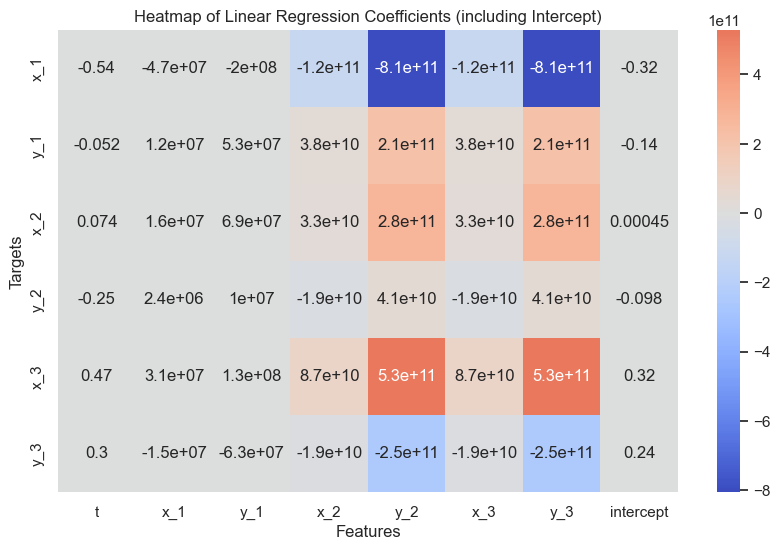

In [105]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),       
    ('regressor', LinearRegression())   
])

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline.fit(X_train, y_train)

coefficients = pipeline.named_steps['regressor'].coef_  # shape = (n_targets, n_features)
intercepts = pipeline.named_steps['regressor'].intercept_  # shape = (n_targets,)

# Afficher les coefficients pour chaque target
for i, target in enumerate(target_cols):
    print(f"\nCoefficients pour {target} :")
    for col, coef in zip(input_cols, coefficients[i]):
        print(f"  {col}: {coef}")
    print(f"Intercept: {intercepts[i]}")

# Créer un DataFrame pour les coefficients et ajouter l'intercept
coef_df = pd.DataFrame(coefficients, index=target_cols, columns=input_cols)
coef_df['intercept'] = intercepts  # ajouter l'intercept comme dernière colonne

plt.figure(figsize=(10, 6))
sns.heatmap(coef_df, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap of Linear Regression Coefficients (including Intercept)")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.show()

In [376]:
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline.predict(X_val) 


rmse_value = root_mean_squared_error(y_val, y_pred_val)#fonction de la librairie
print("RMSE global :", rmse_value)

RMSE global : 1.4571219793246797


In [378]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.show()

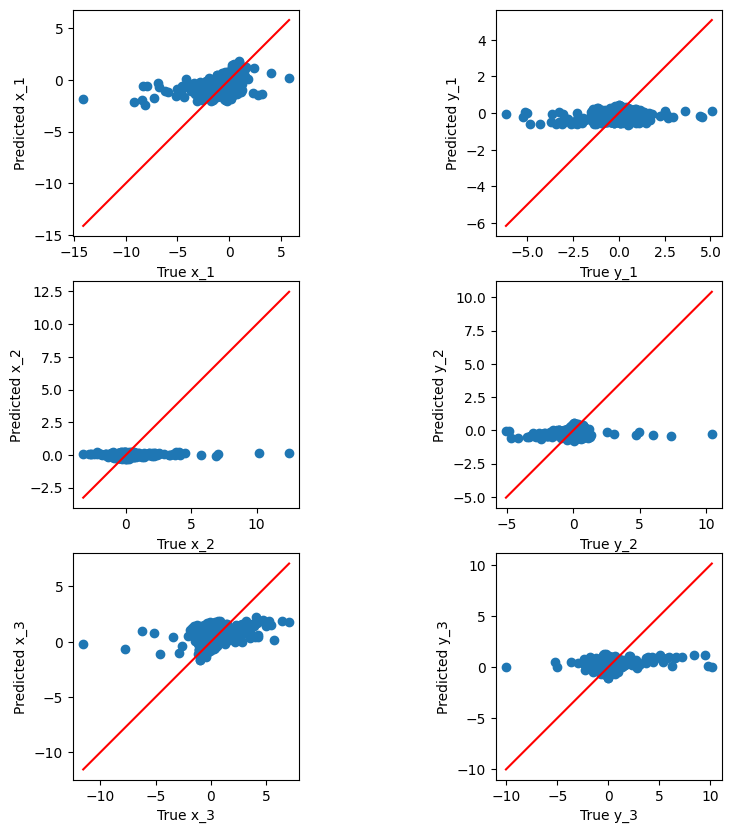

In [382]:
#Prends des points randoms si >500 points
plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")